In [1]:
from DIG import DIG
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma

2024-06-11 16:17:04.457625: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 16:17:04.463622: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 16:17:04.567763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 16:17:06.540441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preparing the Data for tests -- DIG


 

#### Ideas: 
1. We currently force that each point can only have one anchor (because we assume its a one to one correspondonce). However, what if we removed that limitation? Would it be better? My supporting thought for this, is if the algorithm is fairly confident that two points are anchors, they are very similar, and so the algorithm would benefit from thinking them as anchors anyways; even though we know one of the points are wrong
    - > Test setting it to the value instead as of an anchor
2. Sometimes, our hold_out_anchor scores a remarkably high distance from each other. We can maybe set a thing that if no anchors are within the threshold, we can make that hold_out_anchor actually an anchor -- my guess is that it will have the greatest effect on the alignment.

### Questions:
1. How does the second max affect things? (Should it be kept at 1, or found somehow?)

In [2]:
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="glass.csv", split = "random", percent_of_anchors= [0.2], verbose = 2)


 
 
---------------------------       Initalizing class with glass.csv data       ---------------------------

Splitting the data randomly
Split A features shape: (214, 2)
Split B Features shape (214, 7)
MDS initialized with 2 components
The knn values are: (2, 7, 12, 17, 22, 27, 32, 37, 42, 47)


In [3]:
test1 = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 4, link = "None", verbose = 2, density_normalization = False)

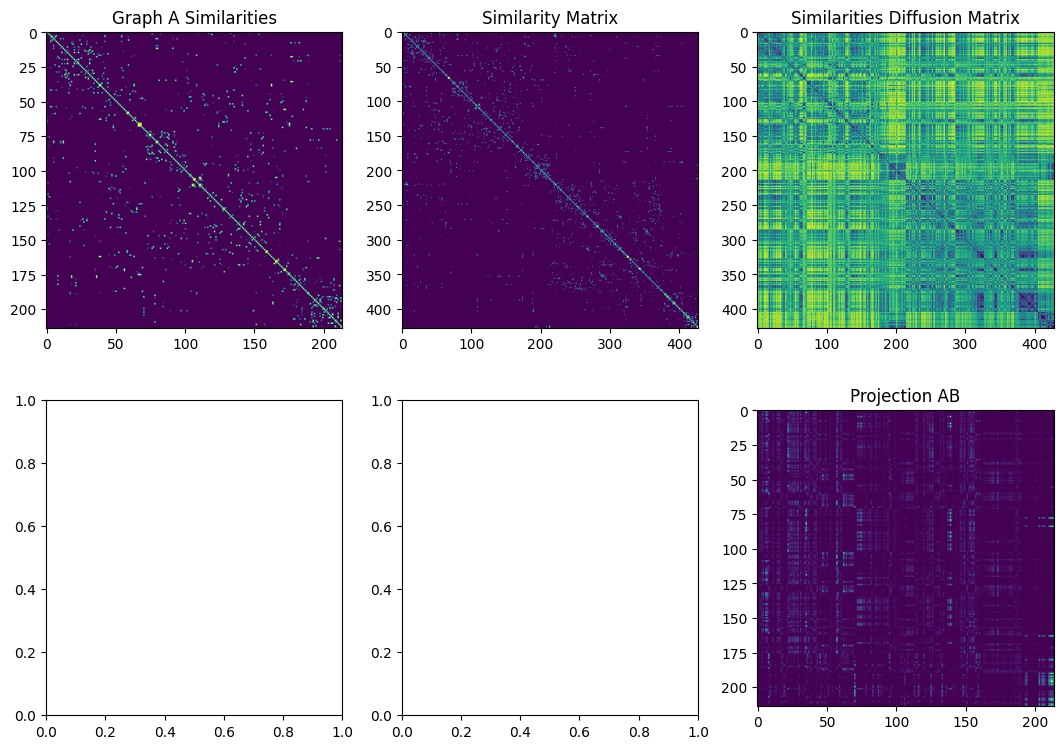

In [4]:
test1.plot_graphs()

Model Stress: 2116.3183832683726
Cross Embedding: 0.4439252336448598
FOSCTTM: 0.35880862957463533


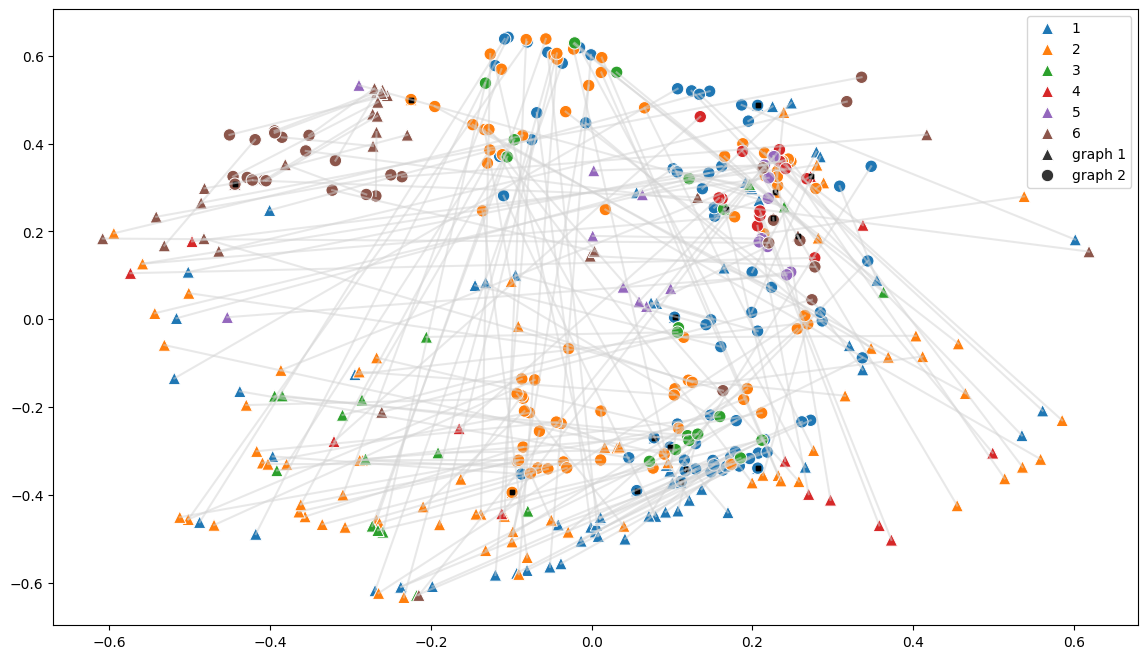

In [5]:
test1.plot_emb(labels = dc.labels_doubled, block = test1.sim_diffusion_matrix)

# Finding Anchors Test


In [6]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:15], t = -1, knn = 2, link = "None", verbose = 2)
array = test.sim_diffusion_matrix[:test.len_A, test.len_A:]

#Get rid of the known anchors
#array[test.known_anchors[:, 0], :] = np.inf
array[:, test.known_anchors[:, 1]] = np.inf

#Loop through each row
for row in range(0, test.len_A):
    #Get the anchor value
    anc_value = array[row, row]

    #Get the min position value
    min_pos = np.argmin(array[row, :])

    #Get the min value
    min_value = np.min(array[row, :])

    print(f"Row {row}: The mininum position is {min_pos} with a value of {min_value}. The anchor value is {anc_value}\n")

Row 0: The mininum position is 170 with a value of 0.2566005219557944. The anchor value is 0.2924453715275103

Row 1: The mininum position is 110 with a value of 0.3568998060306743. The anchor value is 0.7124356987308302

Row 2: The mininum position is 110 with a value of 0.39285791817575666. The anchor value is 0.5212081929944651

Row 3: The mininum position is 147 with a value of 0.21155935234894696. The anchor value is 0.24803851125375684

Row 4: The mininum position is 4 with a value of 0.04924366948227416. The anchor value is 0.04924366948227416

Row 5: The mininum position is 74 with a value of 0.34739045477789826. The anchor value is 0.6923545180872146

Row 6: The mininum position is 4 with a value of 0.0266027026329002. The anchor value is inf

Row 7: The mininum position is 147 with a value of 0.2296372141546987. The anchor value is 0.3275911389963132

Row 8: The mininum position is 95 with a value of 0.06784553706079807. The anchor value is inf

Row 9: The mininum position is

### Methods Below

In [7]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    array = np.array(self.sim_diffusion_matrix[:self.len_A, self.len_A:])

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.inf
    array[:, self.known_anchors[:, 1]] = np.inf

    if len(hold_out_anchors) > 1:
        hold_out_anchors = np.array(hold_out_anchors)
        array[hold_out_anchors[:, 0], :] = np.inf
        array[:, hold_out_anchors[:, 1]] = np.inf
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = np.array(coordinates[:anchor_limit * anchor_limit])
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*100)
    
    # Extract row and column indices
    rows = selected_coords[:, 0]
    cols = selected_coords[:, 1]

    # Create meshgrid of indices
    row_i, row_j = np.meshgrid(rows, rows)
    col_i, col_j = np.meshgrid(cols, cols)

    # Create a mask where row_i != row_j and col_i != col_j
    mask = (row_i != row_j) & (col_i != col_j)

    # Fill the cost_matrix using the mask
    cost_matrix[mask] = array[row_j[mask], col_j[mask]]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


In [8]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [9]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

pairs, array = _find_possible_anchors(test, anchor_limit = None, hold_out_anchors = dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.7608764323623624


Pair 1: (29, 58) with value 0.052776783190265845
Pair 2: (3, 40) with value 0.06673274155766858
Pair 3: (54, 16) with value 0.06808716523279326
Pair 4: (17, 130) with value 0.06912483694144565
Pair 5: (42, 24) with value 0.06947851737113914
Pair 6: (162, 110) with value 0.07339036389458971
Pair 7: (38, 111) with value 0.07420068885510149
Pair 8: (135, 4) with value 0.0773509954578278
Pair 9: (157, 103) with value 0.07799136360154826
Pair 10: (63, 131) with value 0.08115699905051144
Pair 11: (136, 11) with value 0.08237718079053444
Pair 12: (127, 69) with value 0.08452348429602792
Pair 13: (53, 152) with value 0.08525488413590815
Pair 14: (211, 104) with value 0.08971421566675322
Pair 15: (65, 43) with value 0.09435242340435526
Pair 16: (99, 25) with value 0.09678933921115382
Pair 17: (0, 64) with value 0.09692935812793524
Pair 18: (130, 107) with value 0.09810360627668929
Pair 19: (96, 82) with value 0.09933952732777947
Pair 20: (128, 48) with value 0.10

## Testing the validification accuracy of this on repeat

In [10]:
def optimize_by_pred_anchors(self, epochs = 3, **find_possible_anchors_kwargs):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
    :anchor_limit: should be an integer. If fixed, it will determine the max anchors the algorithm will find.
    :epochs: the number of iterations the cycle will go through. 
    """
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):

        #Find predicted anchors
        try:
            predicted_anchors, array = _find_possible_anchors(self, **find_possible_anchors_kwargs)
        except:
            #This will occur if we have found the max amount of anchors already
            print("All Anchors have been predicted")
            predicted_anchors = []

        if len(predicted_anchors) < 1:
            print("No new predicted anchors found. Exiting process")

            #Add in the known anchors and reset the known_anchors
            if "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                self.known_anchors = np.concatenate((self.known_anchors, find_possible_anchors_kwargs["hold_out_anchors"]), axis = 0)
        else:

            #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
            if epoch == epochs - 1 and "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                predicted_anchors = np.concatenate((find_possible_anchors_kwargs["hold_out_anchors"], predicted_anchors), axis = 0)

            #Add in the known anchors and reset the known_anchors
            self.known_anchors = np.concatenate((self.known_anchors, predicted_anchors), axis = 0)

        #Reconnect the graphs based on the new anchors
        self.graphAB = self.merge_graphs()
        
        #Get Similarity matrix and distance matricies
        self.similarity_matrix = self.get_pure_matricies(self.graphAB)

        #Get Diffusion Matrix
        self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)

        if len(predicted_anchors) < 1:
            #Process didn't finish
            return False
        
    #Process Finished
    return True

In [11]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)
optimize_by_pred_anchors(test, epochs = 70, anchor_limit = 4, threshold = 0.2)

Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


Threshold: 0.2


All Anchors have been predicted
No new predicted anchors found. Exiting process


False

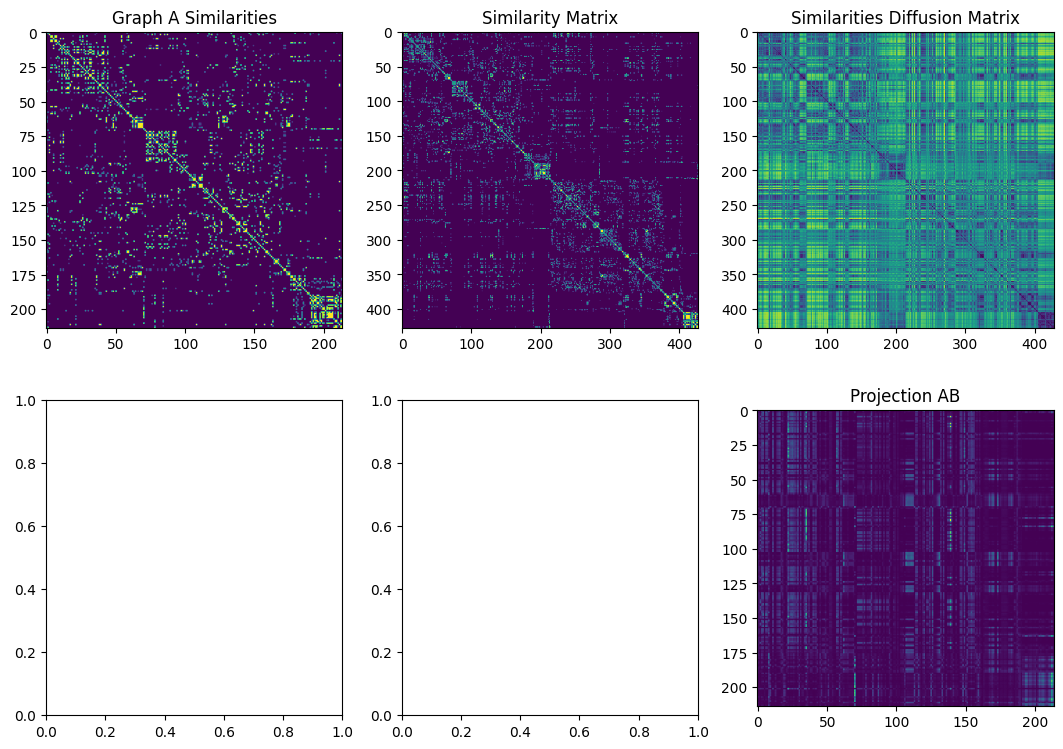

In [12]:
test.plot_graphs()

Model Stress: 586.3511944435286
Cross Embedding: 0.4205607476635514
FOSCTTM: 0.3202463097213731


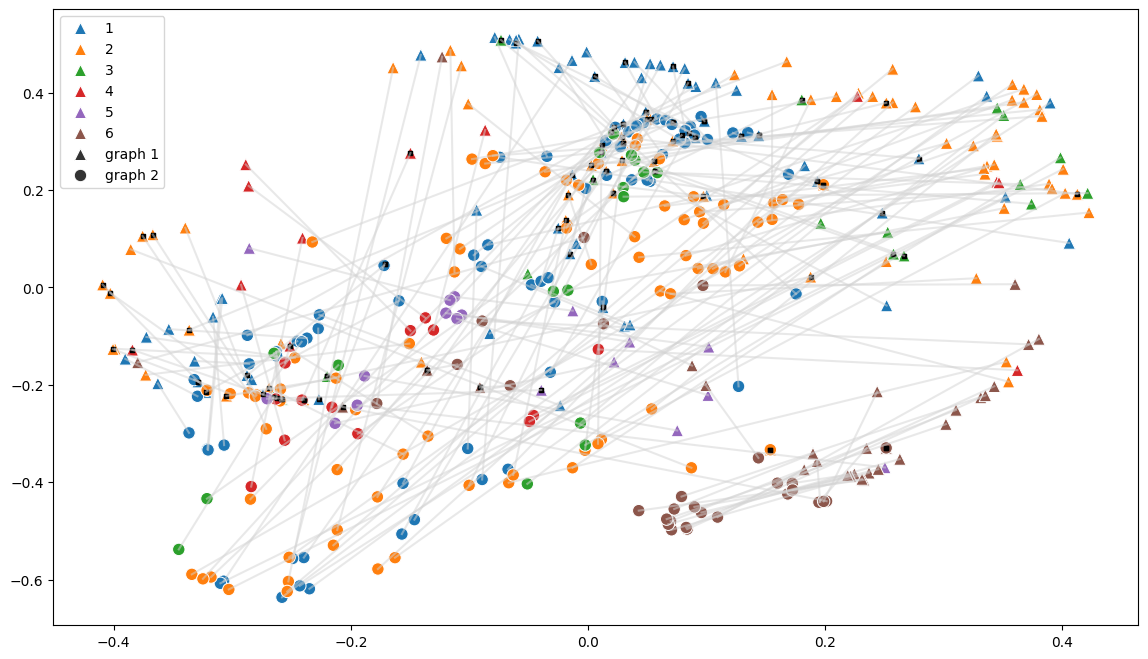

In [13]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

Model Stress: 2116.3183832683726
Cross Embedding: 0.4439252336448598
FOSCTTM: 0.35880862957463533


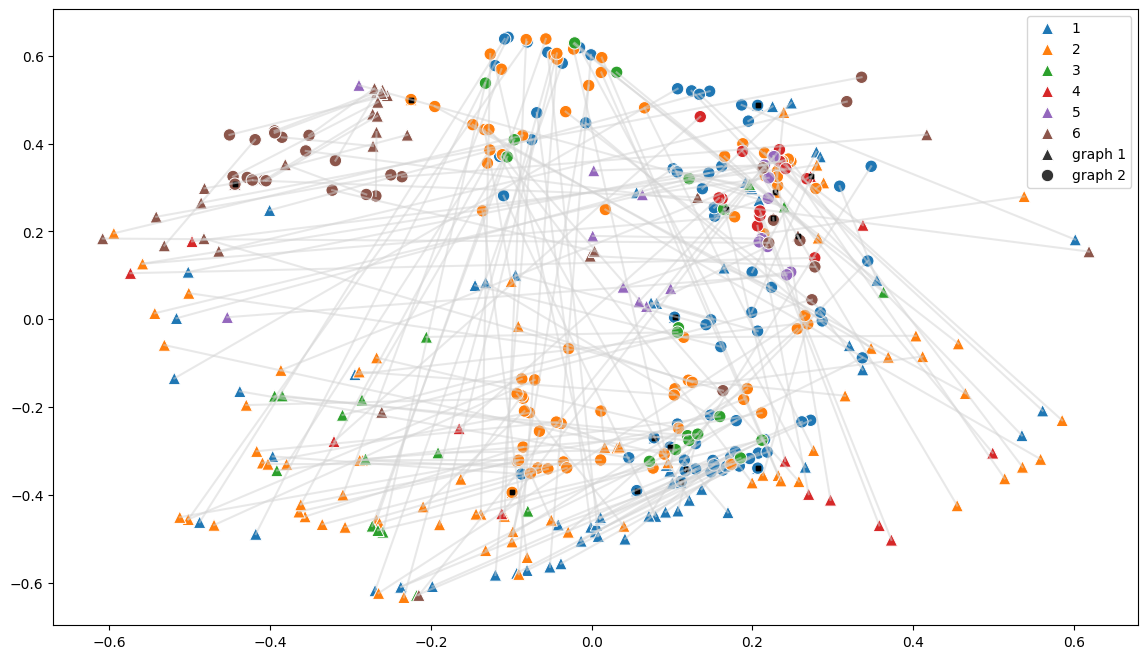

In [14]:
test1.plot_emb(labels = dc.labels_doubled, block = test1.sim_diffusion_matrix)

# Finding close connections alignment 



Maybe there is opportunity here for it to learn things itself? 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This algorithm does the following things:
1. It seeks to find the points that have the least distance to each other (and hopefully they are the same point)
2. It then saves those connection values, and uses them in the future to when rebuilding the graph connections ... (It doesn't save them to known anchors though, but a different variable list)
3. It thens tests the new alignment (If we use labels, we can also compare CE):
    1. If the scores are better, it keeps the alignment. 
    2. if the Scores are worse, it prunes those values and throws out the alignment? (Do we want to add a weight between those values?)
4. Then it repeats the process for a certain amount of epochs or until the algorithm no longer improves
    


In [15]:
def _find_new_connections(self, pruned_connections = [], connection_limit = None, threshold = 0.2): 
    """A helper function that finds and returns a list of possible anchors and their associated wieghts after alignment.
        
    Parameters:
        :connection_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        :pruned_connections: should be a list formated like Known Anchors. The node connections in this list will not be considered
            for possible connections. 
        
    returns possible anchors plus known anchors in a single list"""

    #Keep Track of known-connections 
    known_connections = self.similarity_matrix > 0 #Creates a mask of everywhere we have a connection

    if self.verbose > 0:
        print(f"Total number of Known_connections: {np.sum(known_connections)}")

    #Set our Known-connections to inf values so they are not found and changed
    array = np.array(self.sim_diffusion_matrix) #This is made into an array to ensure we aren't passing by reference
    array[known_connections] = np.inf

    #Modify our array just to be the off-diagonal 
    array = array[:self.len_A, self.len_A:]

    #Add in our pruned connections
    array[pruned_connections] = np.inf

    #Set anchor limit to 1/3 of the unknown data points
    if connection_limit == None:
        #connection_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
        connection_limit = int(array.shape[0] * array.shape[1])

    """ This section actually finds and then curates potential anchors """

    
    # Flatten the array
    array_flat = array.flatten()

    # Get the indices that would sort the array
    smallest_indices = np.argsort(array_flat)

    # Select the indices of the first 5 smallest values
    smallest_indices = smallest_indices[:connection_limit]

    # Convert the flattened indices to tuple coordinates (row, column)
    coordinates = [np.unravel_index(index, array.shape) for index in smallest_indices]

    #Add in coordinate values as the third index in the tuple
    coordinates = [(int(coordinate[0]), int(coordinate[1]), array[coordinate[0], coordinate[1]]) for coordinate in coordinates]

    #Apply the Threshold
    from itertools import takewhile
    coordinates = np.array(list(takewhile(lambda x: x[2] < threshold, coordinates)))

    return coordinates

In [16]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

## Testing the algorithm with many epochs

Idea! Instead of using Hold-out anchors, what if we instead set the threshold based on the distribution of data from the first Epoch?

Reasoning: 
- If we do this, if their are values within them they will work. 
- The values shift from epoch to epoch, so there will be different "learned" connections


Observations:
- Threshold around 0.1 is a good spot usually, although it varies. 
- None for a connection limit always does well, but 1/5 or 1x or 10x of data points beat it out (but took significantly longer). It seems the less the better the CE, but longer time it will take


Best choice
- None : 1
- 1/5 : 2
- 10x : 2
- 1x: 1

In [17]:
def _update_anchors(self, anchors):
    """If there are no anchors, this algorithm resets all the data associated with that.
    It should be only accessed by the class"""

    #Add anchors
    self.known_anchors = np.concatenate((self.known_anchors, anchors), axis = 0)

    #Reconnect the graphs based on the new anchors
    self.graphAB = self.merge_graphs()
    
    #Get Similarity matrix and distance matricies
    self.similarity_matrix = self.get_pure_matricies(self.graphAB)

In [18]:
def optimize_by_creating_connections(self, epochs = 3, threshold = "auto", connection_limit = "auto"):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
        :connection_limit: should be an integer. If set, it will cap out the max amount of anchors found. 
            Best values to try: 1/5 of the length of data, 1/10 length of the data, 10x length of data, or None. 
        :threshold: should be a float. If auto, the algorithm will determine it. It can not be higher than the median of the dataset.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        :pruned_connections: should be a list formated like Known Anchors. The node connections in this list will not be considered
            for possible connections. 
        :epochs: the number of iterations the cycle will go through. 
    """

    #Create a list to return diffusion matrices NOTE: we can delete this later, simply for my testing sanity
    dif_list = []

    #Show the original connections
    if self.verbose > 1:
        print("<><><><><> Beggining Tests. Original Connections show below <><><><><>")
        plt.imshow(self.similarity_matrix)
        plt.show()

    """ TO USE HOLD-OUT ANCHORS -- DOESNT SEEM HELPFUL
    #Set pruned_connections to equal hold_out_anchhor connections if they exist, empty otherwise
    if "hold_out_anchors" in find_possible_connections_kwargs.keys():
        #Firt add the anchor connections
        pruned_connections = [(anchor[0], anchor[1]) for anchor in find_possible_connections_kwargs["hold_out_anchors"]]

        #Add in the the connections of each neighbor to each anchor
        for anchor_pair in find_possible_connections_kwargs["hold_out_anchors"]: #TODO: Vectorize this somehow?

            #Add the connections
            pruned_connections += [(neighbor, anchor_pair[1]) for neighbor in set(self.graph_a.to_igraph().neighbors(anchor_pair[0], mode="out"))]
            pruned_connections += [(anchor_pair[0], neighbor) for neighbor in set(self.graph_b.to_igraph().neighbors(anchor_pair[1], mode="out"))]
        
    else:
        pruned_connections = []"""

    if threshold == "auto":
        #Set the threshold to be the 10% limit of the connections
        threshold = np.sort(self.sim_diffusion_matrix.flatten())[:int(len(self.sim_diffusion_matrix.flatten()) * .1)][-1]

    if connection_limit == "auto":
        #Set the connection limit to be 10x the shape (just because its usualy good and fast)
        connection_limit = 10 * self.len_A

    #Create an empty Numpy array
    pruned_connections = np.array([]).astype(int)

    #Get the current score of the alignment
    current_score = np.mean([self.FOSCTTM(self.sim_diffusion_matrix[self.len_A:, :self.len_A]), self.FOSCTTM(self.sim_diffusion_matrix[:self.len_A, self.len_A:])])

    #Find the Max value for new connections to be set too
    second_max = np.median(self.similarity_matrix[self.similarity_matrix != 0])
    
    if self.verbose > 0:
        print(f"Second max: {second_max}")
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):
        
        if self.verbose > 0:
            print(f"<><><><><><><><><><><><>    Starting Epoch {epoch}    <><><><><><><><><><><><><>")

        #Find predicted anchors
        new_connections = _find_new_connections(self, pruned_connections, threshold = threshold, connection_limit = connection_limit)

        if len(new_connections) < 1:
            print("No new_connections. Exiting process")

            """#Add in the known anchors and reset the known_anchors and other init variables
            if "hold_out_anchors" in find_possible_connections_kwargs.keys():
                _update_anchors(self, find_possible_connections_kwargs["hold_out_anchors"])

                #Get Diffusion Matrix
                self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)
            """

            #Return false to signify we didn't go through all the tests
            return dif_list

        #Continue to show connections
        print(f"New connections found: {len(new_connections)}")

        if self.verbose > 2:
            print("----------------------   Connections Below   ----------------------")
            for i, (row, col, val) in enumerate(new_connections):
                print(f"Pair {i+1}: ({row}, {col}) with value {val}")
                
            print("\n\n\n")

        """
        #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
        if epoch == epochs - 1 and "hold_out_anchors" in find_possible_connections_kwargs.keys():
            _update_anchors(self, find_possible_connections_kwargs["hold_out_anchors"])
        """

        #Copy Similarity matrix
        new_similarity_matrix = np.array(self.similarity_matrix) #We do this redudant conversion to ensure we aren't copying over a reference

        #Add the new connections
        new_similarity_matrix[new_connections[:, 0].astype(int), (new_connections[:, 1] + self.len_A).astype(int)] = second_max - new_connections[:, 2] #The max_value minus is supposed to help go from distance to similarities
        new_similarity_matrix[(new_connections[:, 0] + self.len_A).astype(int) , new_connections[:, 1].astype(int)] = second_max - new_connections[:, 2] #This is so we get the connections in the other off-diagonal block

        #Show the new connections
        if self.verbose > 1:
            plt.imshow(new_similarity_matrix)
            plt.show()
        
        #Get new Diffusion Matrix
        new_sim_diffusion_matrix, new_projectionAB, new_projectionBA = self.get_diffusion(new_similarity_matrix, self.t, link = self.link)

        #Get the new score
        new_score = np.mean([self.FOSCTTM(new_sim_diffusion_matrix[self.len_A:, :self.len_A]), self.FOSCTTM(new_sim_diffusion_matrix[:self.len_A, self.len_A:])])

        #See if the extra connections helped
        if new_score < current_score:
            print(f"The new connections improved the alignment by {current_score - new_score}\n-----------     Keeping the new alignment. Continuing...    -----------\n")
            
            #Add it to diff_lists
            dif_list.append(new_sim_diffusion_matrix)

            #Reset all the class variables
            self.similarity_matrix = new_similarity_matrix
            self.sim_diffusion_matrix = new_sim_diffusion_matrix
            self.projectionAB = new_projectionAB
            self.projectionBA = new_projectionBA

            #Reset the score
            current_score = new_score

        else:
            print(f"The new connections worsened the alignment by {new_score - current_score}\n-----------     Pruning the new connections. Continuing...    -----------\n")

            #Add the added connections to the the pruned_connections
            if len(pruned_connections) < 1:
                pruned_connections = new_connections[:, :2].astype(int)
            else:
                pruned_connections = np.concatenate([pruned_connections, new_connections[:, :2]]).astype(int)
        
    #Process Finished
    print("<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>")
    return dif_list

In [19]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 4, link = "None", verbose = 1, density_normalization = False)

results = optimize_by_creating_connections(test, epochs = 10000, connection_limit = 2000, threshold = "auto") #10x .51 nd 0.26, 1/5, 1

Second max: 0.667667029362593
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 3126
New connections found: 2000
The new connections improved the alignment by 0.06584636212769679
-----------     Keeping the new alignment. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 7094
New connections found: 2000
The new connections improved the alignment by 0.032208053105074685
-----------     Keeping the new alignment. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 11064
New connections found: 2000
The new connections improved the alignment by 0.008385011791422814
-----------     Keeping the new alignment. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 3    <><><><><><><><><><><><><>
Total number of Known_connections: 15050
New c

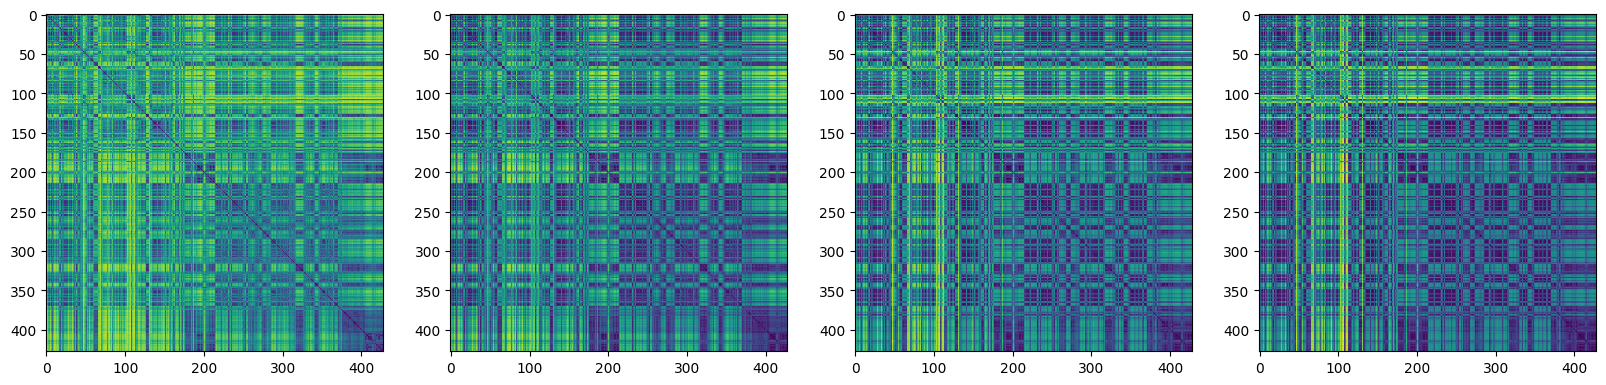

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
try:
    axs[0].imshow(results[0])
    axs[1].imshow(results[1])
    axs[2].imshow(results[-2])
    axs[3].imshow(results[-1])
except:
    print("Not enough passed epochs")

(<matplotlib.image.AxesImage at 0x7f06c12042e0>, 1.0, 0.0)

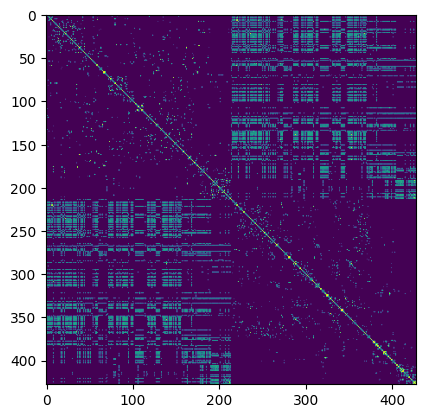

In [21]:
plt.imshow(test.similarity_matrix), np.max(test.similarity_matrix), np.min(test.similarity_matrix)

(<matplotlib.image.AxesImage at 0x7f06c10706a0>, 1.0, 0.0)

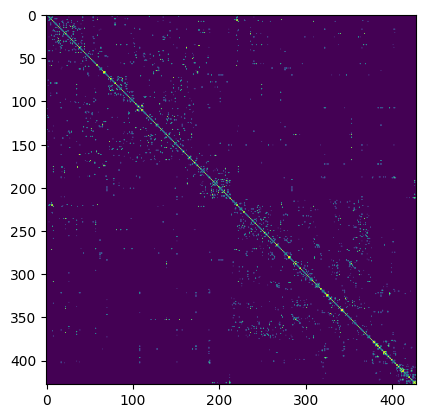

In [22]:
plt.imshow(test1.similarity_matrix), np.max(test1.similarity_matrix), np.min(test1.similarity_matrix)

Model Stress: 212.982598338798
Cross Embedding: 0.3925233644859813
FOSCTTM: 0.22774914839723992


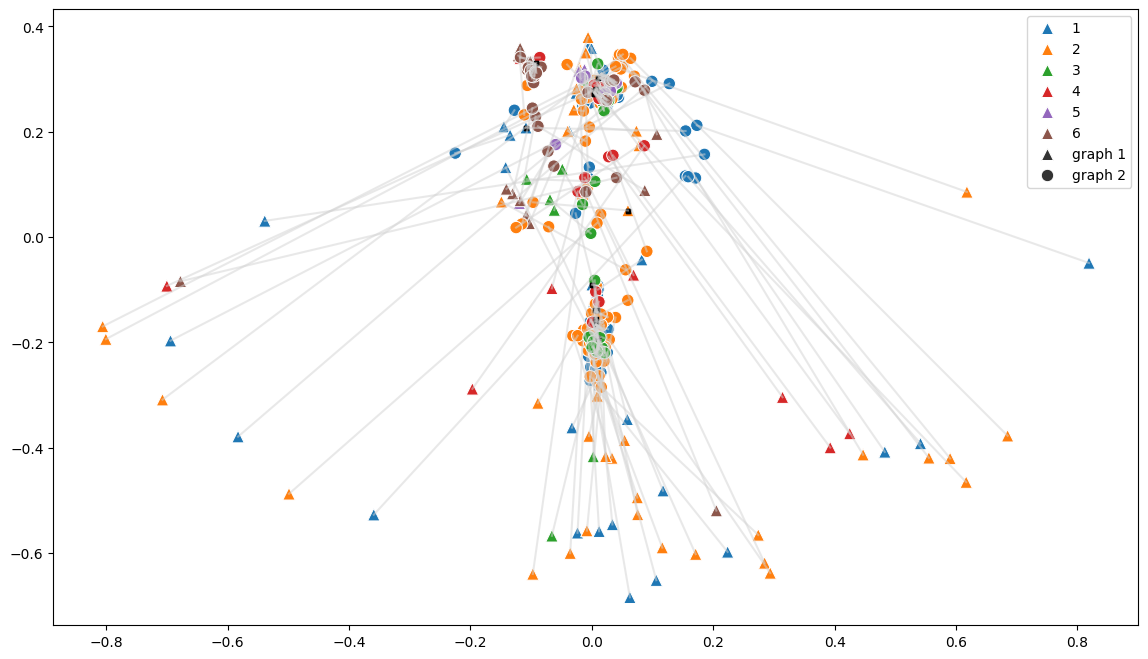

In [24]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

Model Stress: 2116.3183832683726
Cross Embedding: 0.4439252336448598
FOSCTTM: 0.35880862957463533


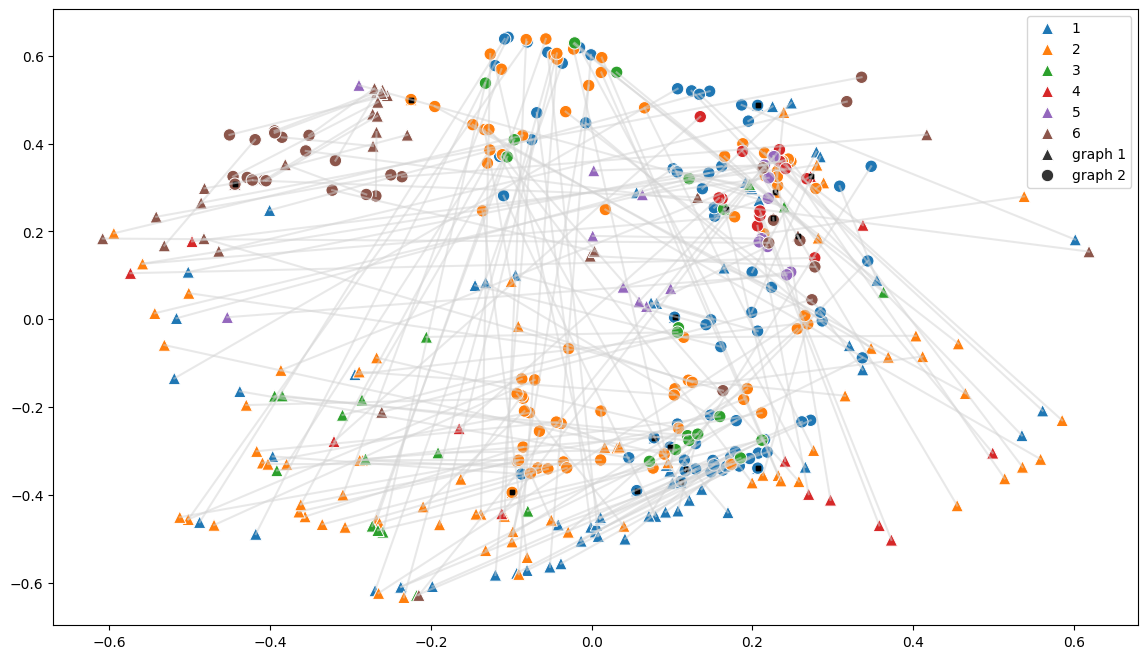

In [25]:
#Compare to original 
test1.plot_emb(labels = dc.labels_doubled, block = test1.sim_diffusion_matrix)

Iris Results --- Without Pruning
1. Major sucess! With many epochs, and many connections, it did very well on distort split (improving CE metric 0.4 and FOSCTTM by 0.5)
2. With an even split, the CE was improved by 0.4, and FOSTTCM was slightly worse
3. Did slightly better on Random splits
4. MAJOR SUCESS with turn. Practically made FOSCTTM 0, and CE was slightly better
5. Great success with skewed. Upped CE by 3%, and lowered FOSCTTM by 2%

Iris Results with Pruning
1. Similar with Skewed
2. EVEN: Both metrics improved by 0.2
3. Huge success with Random splits, improving each metric by nearly 5%
4. TURN: slightly worse CE, but huge improvements on FOSCTTM (about 5%)
5. DISTORT: Marginally better across both Metrics. 

Tests reducing "Second_max"
1. TURN: Very helpful: improved CE by 2%
2. Not Helpful with Skewed
3. Controversial: Reduced Fosctm by 10% but lowed CE by 4%
4. Helpful for EVEN


Hyper-parameters adjustments
1. It seems that it helps to form as much connections as possible. Connection_limit seems to be best when set to None
2. The Threshold Seems to do great at 10% of the data (or a little less)


<Axes: >

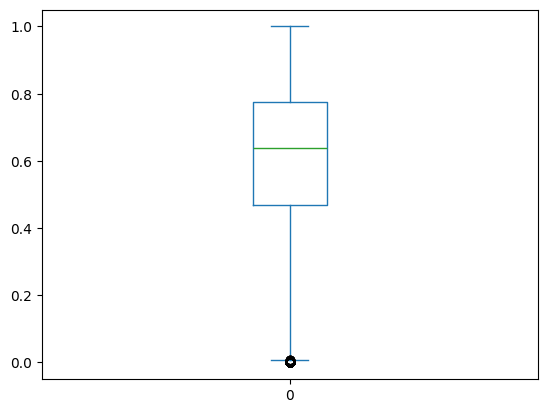

In [26]:
#Viewing the distribution
all_points  = pd.DataFrame(test1.sim_diffusion_matrix.flatten())
all_points.plot(kind = "box")

In [27]:
all_points.describe()

0
count  183184.000000
mean        0.609529
std         0.208911
min         0.000000
25%         0.469030
50%         0.637266
75%         0.776538
max         1.000000

In [28]:
#Find what percent of data is below 0.2
np.sum(all_points < 0.17) / len(all_points)

0    0.031084
dtype: float64

In [29]:
#Find what value 10% of the values are under
value = int(len(all_points) * .1)

np.sort(test1.sim_diffusion_matrix.flatten())[:value][-1]

0.3127453272807393

# Density Normalization Tests

The density algorithm takes a bunch of time...

In [30]:
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="ecoli_5.csv", split = "even", percent_of_anchors= [0.3], verbose = 2)


 
 
---------------------------       Initalizing class with ecoli_5.csv data       ---------------------------

Spliting the data evenly
Split A features shape: (327, 4)
Split B Features shape (327, 3)
MDS initialized with 3 components
The knn values are: (2, 9, 16, 23, 30, 37, 44, 51, 58, 65)


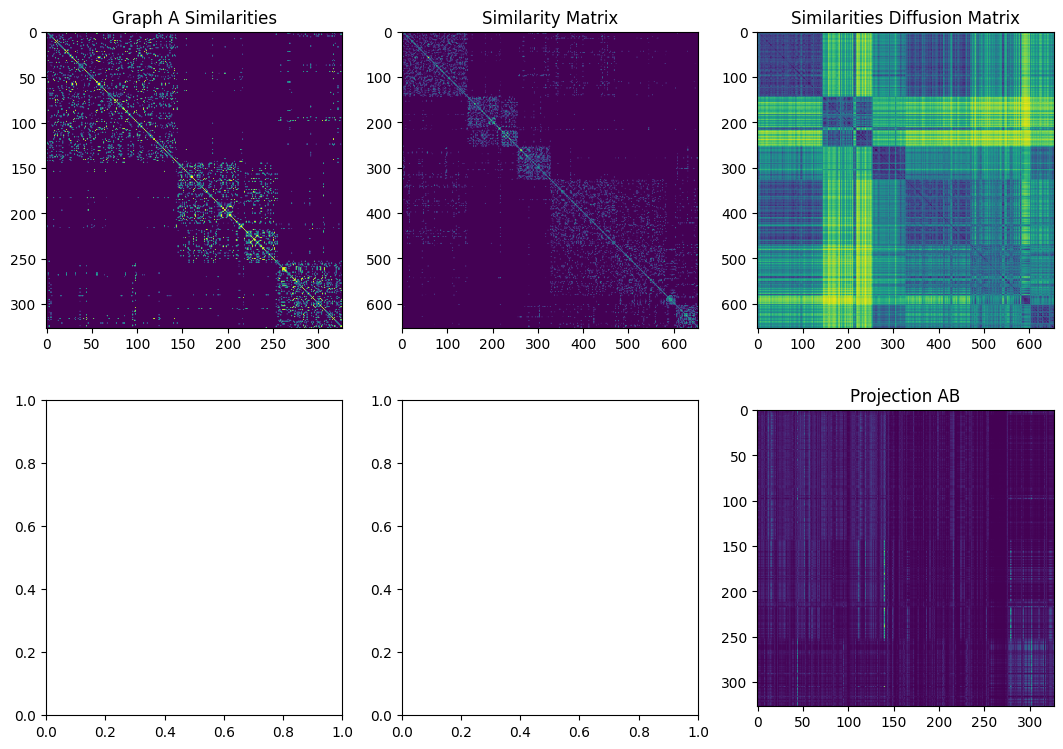

In [31]:
trial = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2, density_normalization = False)
trial.plot_graphs()

Model Stress: 965.2485317119565
Cross Embedding: 0.5565749235474006
FOSCTTM: 0.3966744288266047


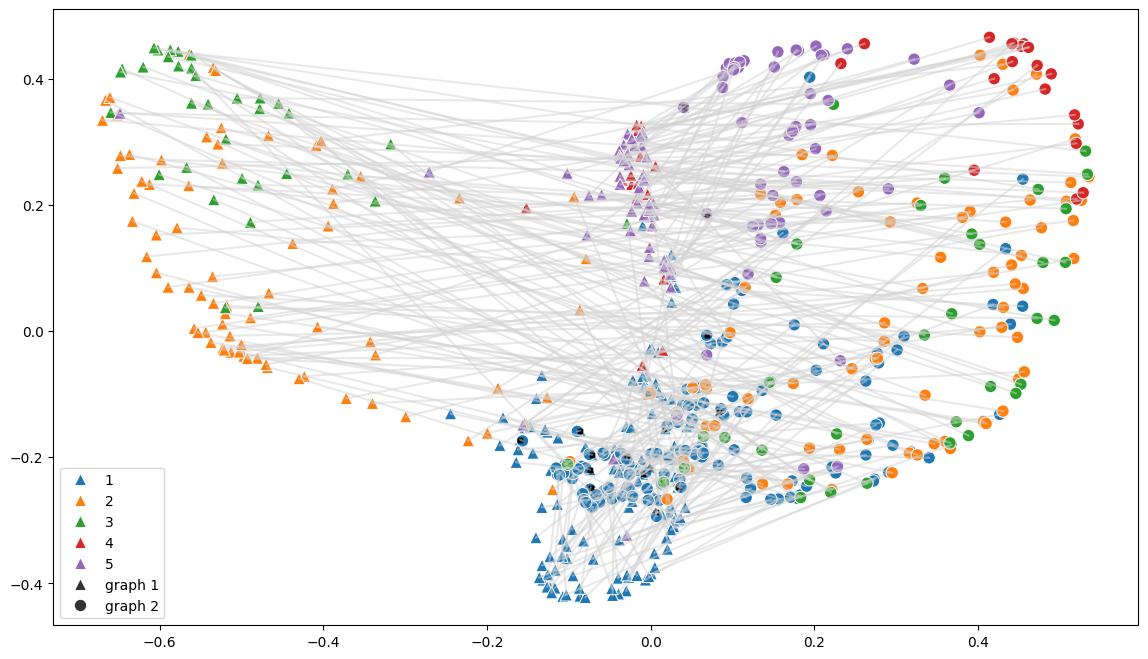

In [32]:
trial.plot_emb(labels = dc.labels_doubled, n_comp = 2, block = trial.sim_diffusion_matrix)

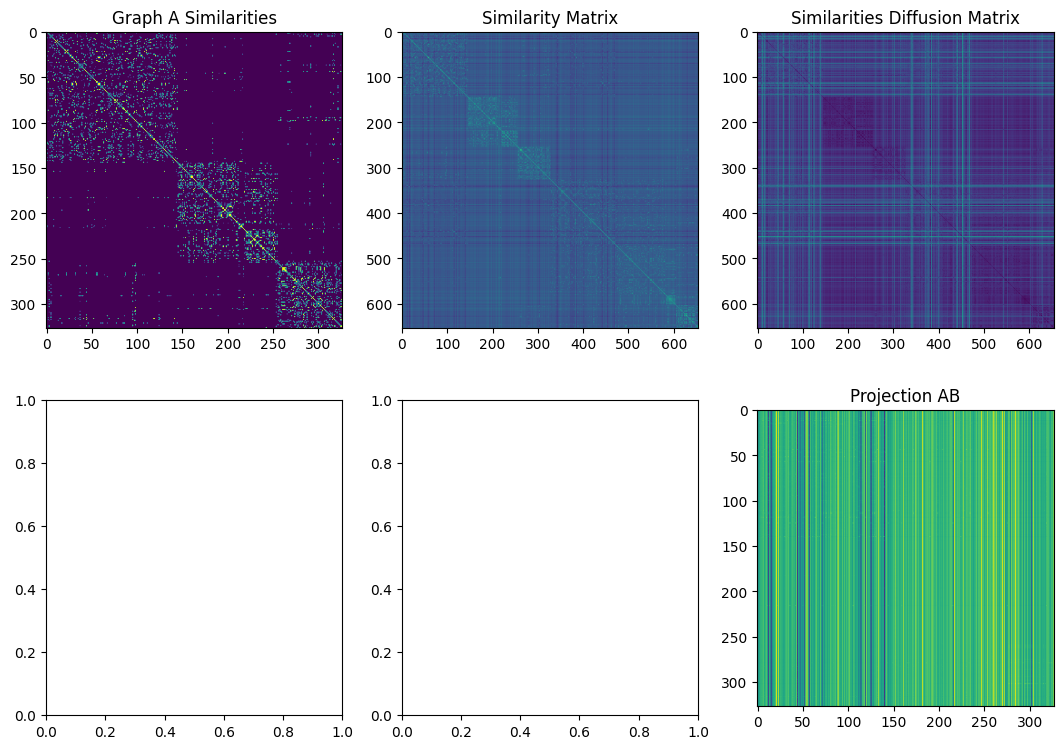

In [33]:
trial2 = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2, density_normalization = True)
trial2.plot_graphs()

Model Stress: 485.7582193230768
Cross Embedding: 0.4923547400611621
FOSCTTM: 0.4181279166549766


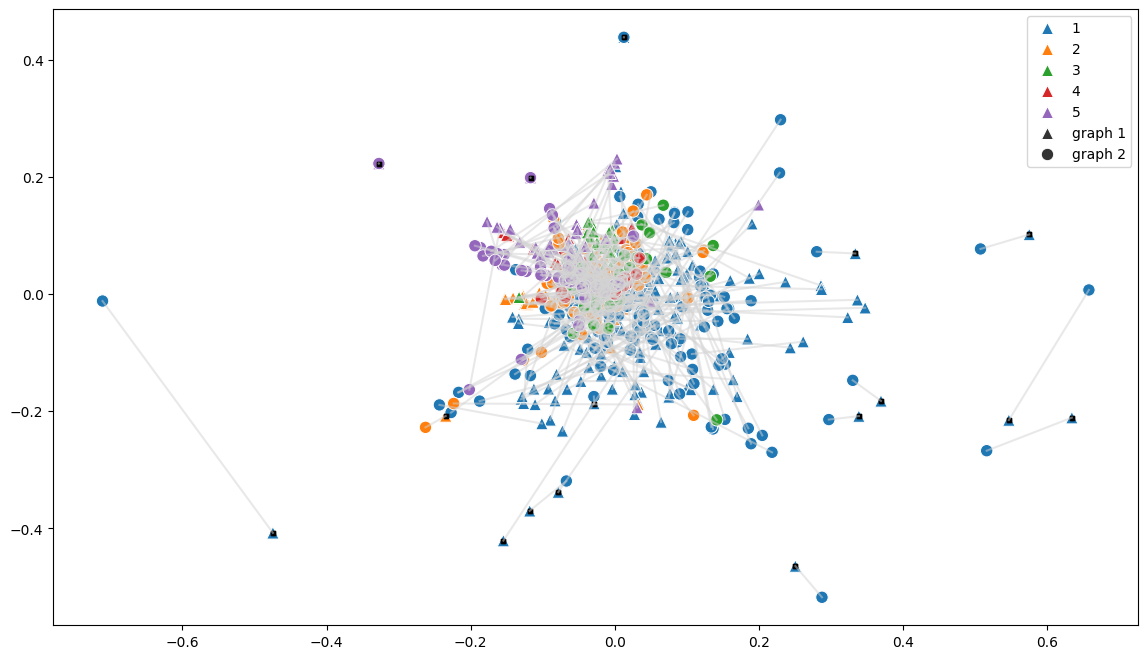

In [34]:
trial2.plot_emb(labels = dc.labels_doubled, n_comp = 2, block = trial2.sim_diffusion_matrix)

# Testing with SPUD

In [35]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors3(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    len_A = self.graphA.vcount()
    array = self.block[:len_A, len_A:]

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = array[hold_out_anchors[0][0], hold_out_anchors[0][1]]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.NaN
    array[:, self.known_anchors[:, 1]] = np.NaN

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.NaN
    array[:, hold_out_anchors[:, 1]] = np.NaN
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*10)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


In [36]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs",  knn = 5, kind = "pure", show = True)

KeyboardInterrupt: 

In [ ]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [ ]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs", kind = "pure", knn = 5, show = False)

pairs, array = _find_possible_anchors3(spud, anchor_limit = 15, threshold =0.1, hold_out_anchors=dummy_array2)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.1


Pair 1: (40, 25) with value 4.026831324399627e-05
Pair 2: (82, 66) with value 8.849540258558386e-05
Pair 3: (91, 101) with value 0.0001599454047140625
Pair 4: (107, 131) with value 0.00019126904471097883
Pair 5: (21, 31) with value 0.00035603605306175345
Pair 6: (51, 88) with value 0.00042951463004647916
Pair 7: (84, 90) with value 0.00048426421539049525
Pair 8: (100, 140) with value 0.0004978900889618387
Pair 9: (33, 11) with value 0.0005748506758199989
Pair 10: (38, 13) with value 0.0006918791627949505
Pair 11: (90, 98) with value 0.0007310777834814708
Pair 12: (137, 125) with value 0.0008167741496411529
Pair 13: (71, 80) with value 0.0008479085758416605
Pair 14: (94, 92) with value 0.0008499665961482217
Pair 15: (37, 45) with value 0.0009312834225209954
